**Install library**

In [ ]:
!pip install tensorflow numpy pandas scikit-learn matplotlib seaborn kaggle

**Import Library**

In [42]:
import os
from collections import Counter
from google.colab import files
import matplotlib.pyplot as plt
import cv2
import shutil
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import seaborn as sns

**Preparing weather dataset**

In [ ]:
# Upload kaggle.json
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jehanbhathena/weather-dataset
!unzip weather-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/frost/3913.jpg  
  inflating: dataset/frost/3914.jpg  
  inflating: dataset/frost/3915.jpg  
  inflating: dataset/frost/3916.jpg  
  inflating: dataset/frost/3917.jpg  
  inflating: dataset/frost/3918.jpg  
  inflating: dataset/frost/3919.jpg  
  inflating: dataset/frost/3920.jpg  
  inflating: dataset/frost/3921.jpg  
  inflating: dataset/frost/3922.jpg  
  inflating: dataset/frost/3923.jpg  
  inflating: dataset/frost/3924.jpg  
  inflating: dataset/frost/3925.jpg  
  inflating: dataset/frost/3926.jpg  
  inflating: dataset/frost/3927.jpg  
  inflating: dataset/frost/3928.jpg  
  inflating: dataset/frost/3929.jpg  
  inflating: dataset/frost/3930.jpg  
  inflating: dataset/frost/3931.jpg  
  inflating: dataset/frost/3932.jpg  
  inflating: dataset/frost/3933.jpg  
  inflating: dataset/frost/3934.jpg  
  inflating: dataset/frost/3935.jpg  
  inflating: dataset/frost/3936.jpg  
  inflating: dataset/frost/3937.jpg  

**Data Exploration**

In [5]:
data_dir = 'dataset'
classes = os.listdir(data_dir)
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
print("Class distribution:", class_counts)

Class distribution: {'hail': 591, 'sandstorm': 692, 'dew': 698, 'rainbow': 232, 'glaze': 639, 'rime': 1160, 'fogsmog': 851, 'snow': 621, 'rain': 526, 'frost': 475, 'lightning': 377}


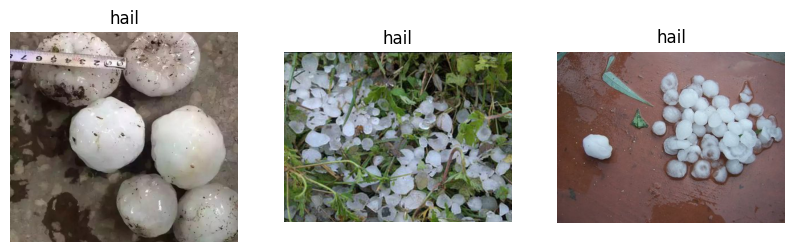

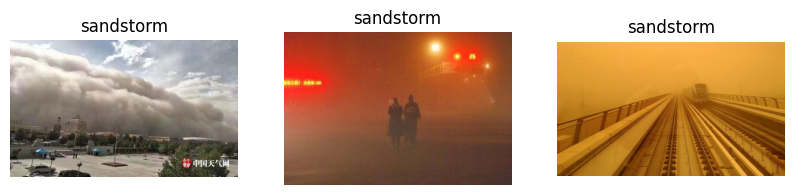

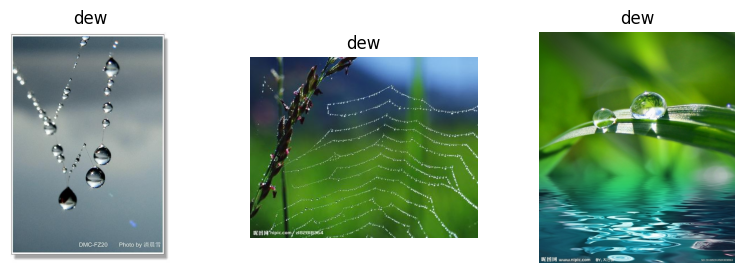

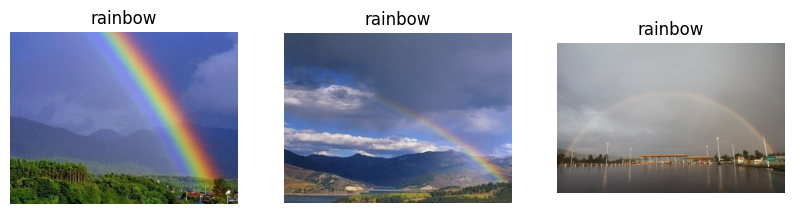

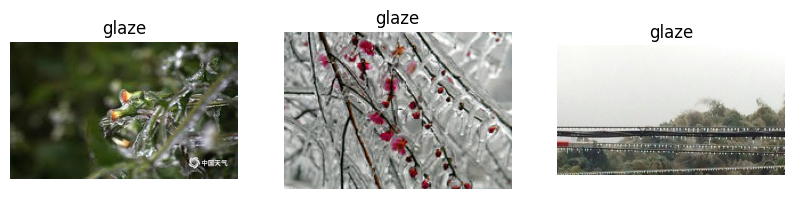

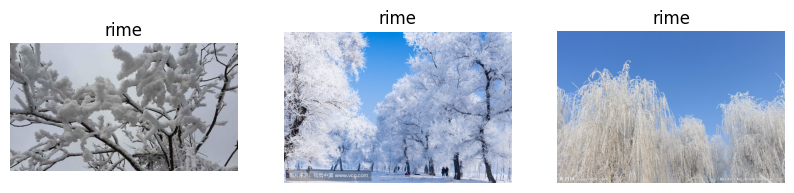

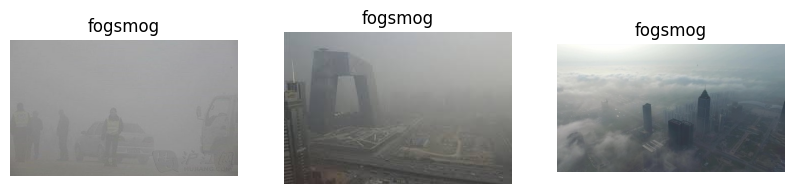

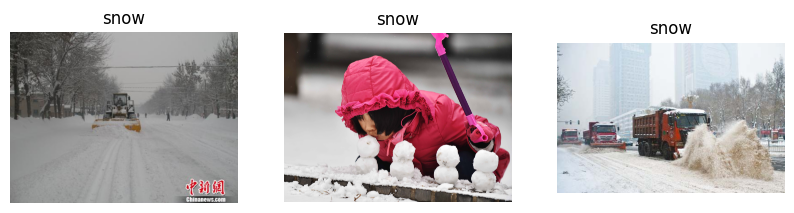

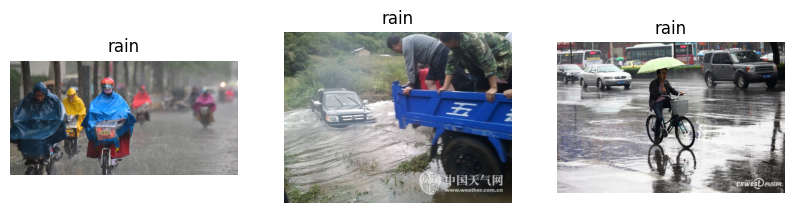

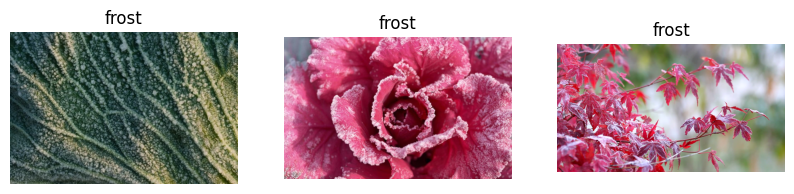

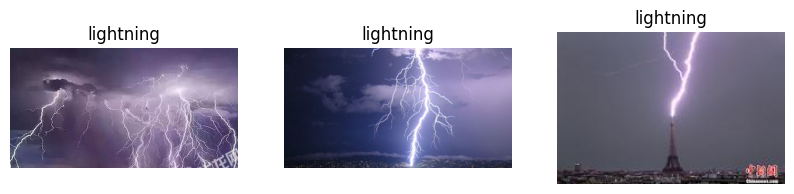

In [6]:
def display_sample_images(data_dir, classes, num_samples=3):
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        images = os.listdir(cls_path)[:num_samples]
        plt.figure(figsize=(10, 3))
        for i, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
        plt.show()

display_sample_images(data_dir, classes)

**Data Processing**



1.   Split Dataset


In [7]:
def split_dataset(data_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.15):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        images = os.listdir(cls_path)
        train_imgs, temp_imgs = train_test_split(images, train_size=train_size, stratify=[cls]*len(images), random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, stratify=[cls]*len(temp_imgs), random_state=42)

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))
        for img in test_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

split_dataset('dataset', 'data/train', 'data/validation', 'data/test')


2.   Data Augmentation and Preprocessing



In [17]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=20,           # Rotate images up to 20 degrees
    width_shift_range=0.2,       # Shift width by 20% of total width
    height_shift_range=0.2,      # Shift height by 20% of total height
    shear_range=0.2,             # Apply shear transformation
    zoom_range=0.2,              # Zoom in/out by 20%
    horizontal_flip=True,        # Flip horizontally
    fill_mode='nearest'          # Fill missing pixels with nearest value
)

val_datagen = ImageDataGenerator(rescale=1./255)    # Only rescale for validation
test_datagen = ImageDataGenerator(rescale=1./255)   # Only rescale for testing

# Create generators
train_generator = train_datagen.flow_from_directory(
    'data/train',                # Directory with training images
    target_size=(224, 224),      # Resize all images to 224x224
    batch_size=32,               # Batch size for training
    class_mode='categorical',    # Categorical labels for multi-class
    shuffle=True                 # Shuffle training data for better learning
)

val_generator = val_datagen.flow_from_directory(
    'data/validation',           # Directory with validation images
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False                # No shuffle for validation to match evaluation
)

test_generator = test_datagen.flow_from_directory(
    'data/test',                 # Directory with test images
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False                # No shuffle for consistent test evaluation
)

# Verify the number of classes and samples
print("Training generator classes:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)
print("Number of test samples:", test_generator.samples)

Found 4798 images belonging to 11 classes.
Found 1031 images belonging to 11 classes.
Found 1033 images belonging to 11 classes.
Training generator classes: {'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}
Number of training samples: 4798
Number of validation samples: 1031
Number of test samples: 1033


**CNN Model**

In [34]:
# Load pre-trained MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(11, activation='softmax')(x)  # 11 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,747 (9.88 MB)

 Trainable params: 330,763 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train Model**



1.   Handle Overfitting and Class imbalance



In [35]:
# Class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [36]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


2.   Train model



In [37]:

# Initial training with frozen layers
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 520ms/step - accuracy: 0.4768 - loss: 1.5456 - val_accuracy: 0.7352 - val_loss: 0.8101 - learning_rate: 0.0010
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 452ms/step - accuracy: 0.7045 - loss: 0.7746 - val_accuracy: 0.7750 - val_loss: 0.6332 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 450ms/step - accuracy: 0.7407 - loss: 0.6717 - val_accuracy: 0.7759 - val_loss: 0.6054 - learning_rate: 0.0010
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 448ms/step - accuracy: 0.7596 - loss: 0.6067 - val_accuracy: 0.7856 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 449ms/step - accuracy: 0.7781 - loss: 0.5707 - val_accuracy: 0.8050 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 449ms/step - accuracy: 0.7799 - loss: 0.5566 - val_accuracy: 0.8109 - val_loss: 0.5525 - learning_rate: 0.0010
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 450ms/step - accuracy: 0.



3. Fine-tuning



In [38]:

# Fine-tuning: Unfreeze some layers and retrain with lower learning rate
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Unfreeze the last 10 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 104s 619ms/step - accuracy: 0.7621 - loss: 0.6283 - val_accuracy: 0.7856 - val_loss: 0.8005 - learning_rate: 1.0000e-04
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 457ms/step - accuracy: 0.8362 - loss: 0.4289 - val_accuracy: 0.7498 - val_loss: 1.0494 - learning_rate: 1.0000e-04
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 69s 460ms/step - accuracy: 0.8339 - loss: 0.4281 - val_accuracy: 0.7284 - val_loss: 1.2267 - learning_rate: 1.0000e-04
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 454ms/step - accuracy: 0.8435 - loss: 0.3773 - val_accuracy: 0.7692 - val_loss: 0.8718 - learning_rate: 1.0000e-04
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 74s 491ms/step - accuracy: 0.8583 - loss: 0.3585 - val_accuracy: 0.7818 - val_loss: 0.8259 - learning_rate: 2.0000e-05
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 515ms/step - accuracy: 0.8575 - loss: 0.3475 - val_accuracy: 0.7779 - val_loss: 0.8050 - learning_rate: 2.0000e-05



3.   Visulize training progress



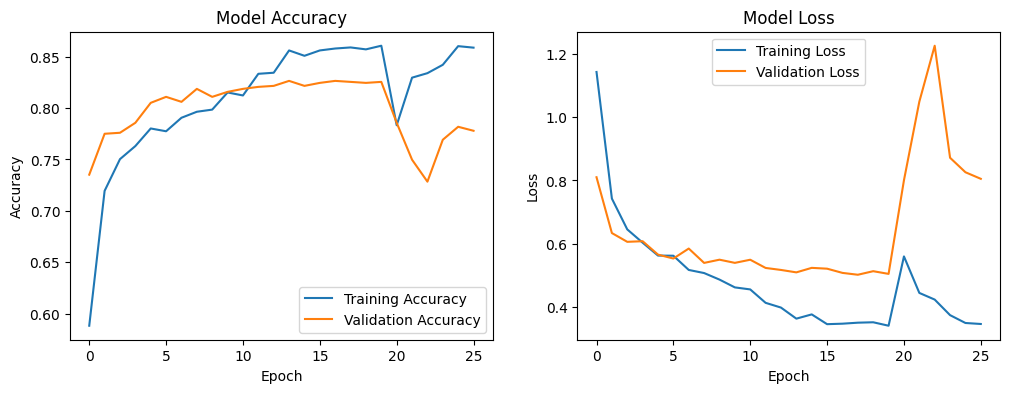

In [39]:
# Combine histories for plotting
history.history['accuracy'] += history_fine.history['accuracy']
history.history['val_accuracy'] += history_fine.history['val_accuracy']
history.history['loss'] += history_fine.history['loss']
history.history['val_loss'] += history_fine.history['val_loss']

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluate model**

In [40]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get predictions and true classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.8099 - loss: 0.6428
Test Accuracy: 0.7919
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step




2.   PCA



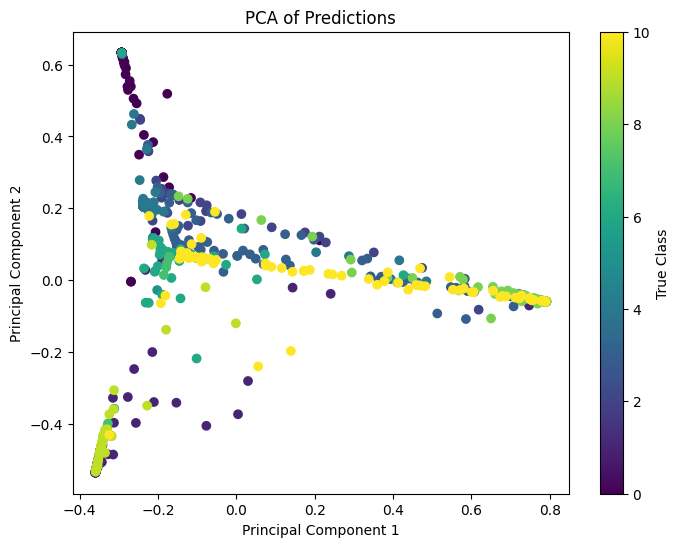

In [43]:
# Apply PCA to predictions
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
prediction_features = pca.fit_transform(predictions)

# Visualize PCA results (scatter plot)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(prediction_features[:, 0], prediction_features[:, 1], c=true_classes, cmap='viridis')
plt.title('PCA of Predictions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='True Class')
plt.show()



3.   Confusion matrix



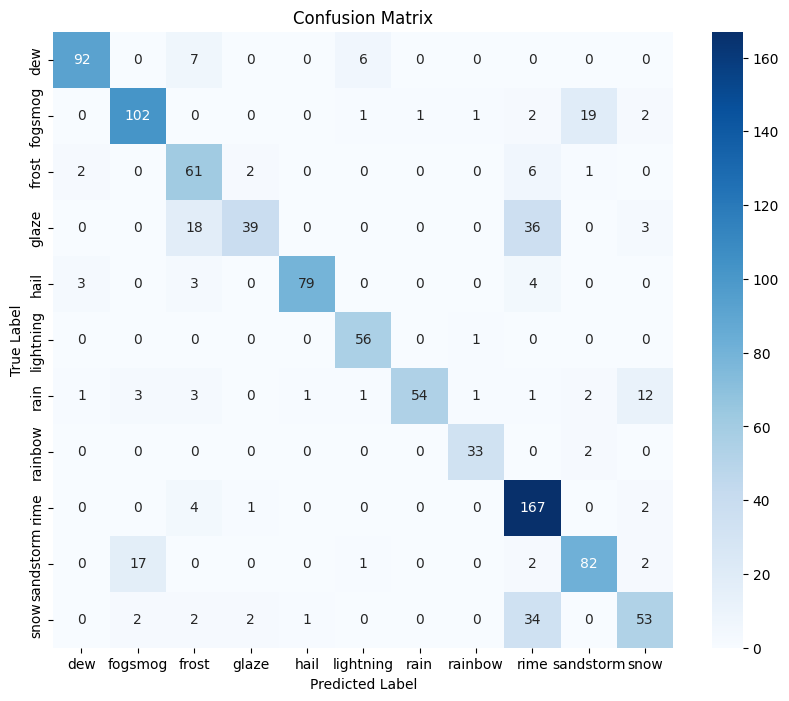

              precision    recall  f1-score   support

         dew       0.94      0.88      0.91       105
     fogsmog       0.82      0.80      0.81       128
       frost       0.62      0.85      0.72        72
       glaze       0.89      0.41      0.56        96
        hail       0.98      0.89      0.93        89
   lightning       0.86      0.98      0.92        57
        rain       0.98      0.68      0.81        79
     rainbow       0.92      0.94      0.93        35
        rime       0.66      0.96      0.78       174
   sandstorm       0.77      0.79      0.78       104
        snow       0.72      0.56      0.63        94

    accuracy                           0.79      1033
   macro avg       0.83      0.79      0.80      1033
weighted avg       0.82      0.79      0.79      1033



In [44]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

**Save model**

In [47]:
model.save('models/weather_cnn.keras')

**Test prediction**

In [46]:
model = load_model('models/weather_cnn.h5')
img = cv2.imread('test.png')
img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
predicted_class = class_labels[np.argmax(prediction)]
print(f'Predicted Weather: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Weather: snow
